## Временные ряды, часть 2.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])

In [3]:
dataset.head()

,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


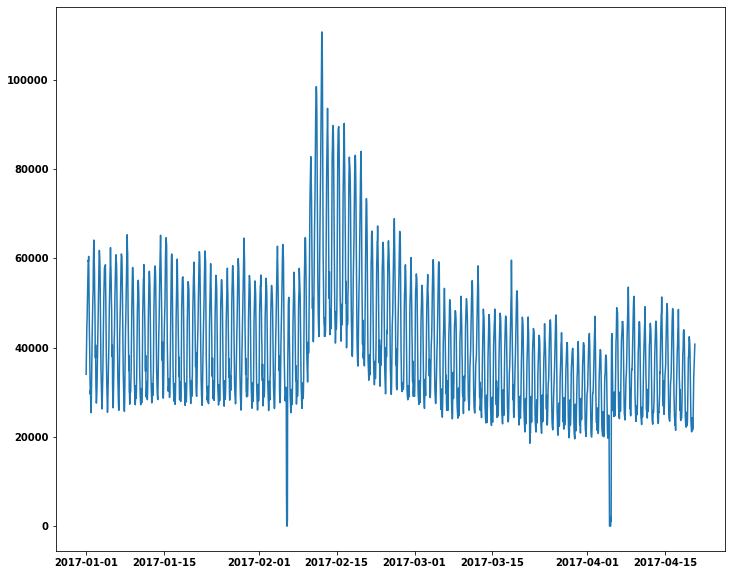

In [4]:
plt.figure(figsize=(12,10))
plt.plot(dataset['Users'])

# Скользящее среднее

### Задание 1. Напишите функцию, вычисляющую скользящее среднее, а именно, по данному ряду series и числу n вычислите среднее значение последних n значений ряда.

In [5]:
def moving_average(series, n):
    return np.average(series[-n:])
    
moving_average(dataset.Users, 24)

29858.333333333332

In [6]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

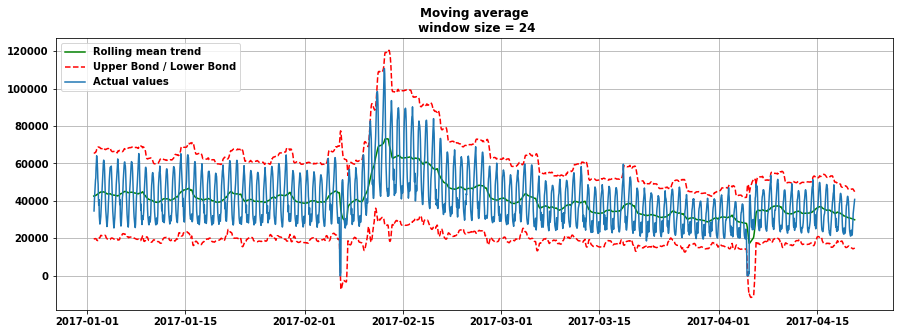

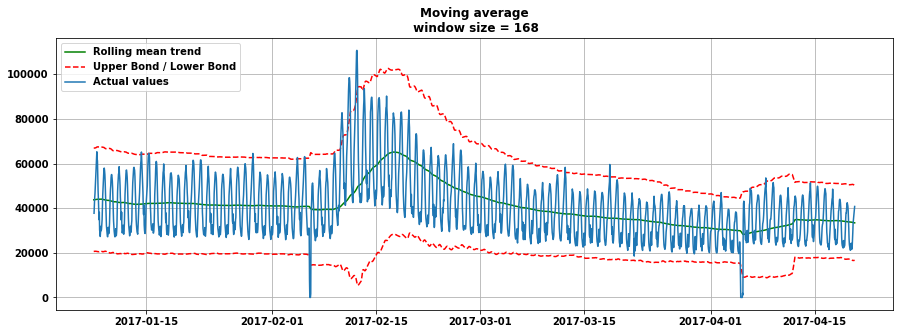

In [7]:
plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

# Взвешенное среднее

### Задание 2. Напишите функцию, вычисляющую взвешенное среднее, а именно, вычисляющую сумму последних значений ряда series с весами, лежащими в списке weights.

$$weights[0] \cdot series[-1] + weights[1] \cdot series[-2] + ... + weights[n] \cdot series[-n-1]$$

In [8]:
def weighted_average(series, weights):
    #your code here
    result = 0.
    for n in range(len(weights)):
        result += weights[n] * series[-n-1]
    return result
    
weighted_average(dataset.Users, [0.6, 0.2, 0.1, 0.07, 0.03])

39907.43

# Экспоненциальное сглаживание

### Задание 3. Напишите функцию для экспоненциального сглаживания, которая каждое значение ряда преобразует по формуле:
$$result[n] = alpha \cdot series[n] + (1 - alpha) \cdot result[n-1]$$

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        #your code here
        result.append(alpha * series[n] + (1-alpha) * result[n-1])
    return result

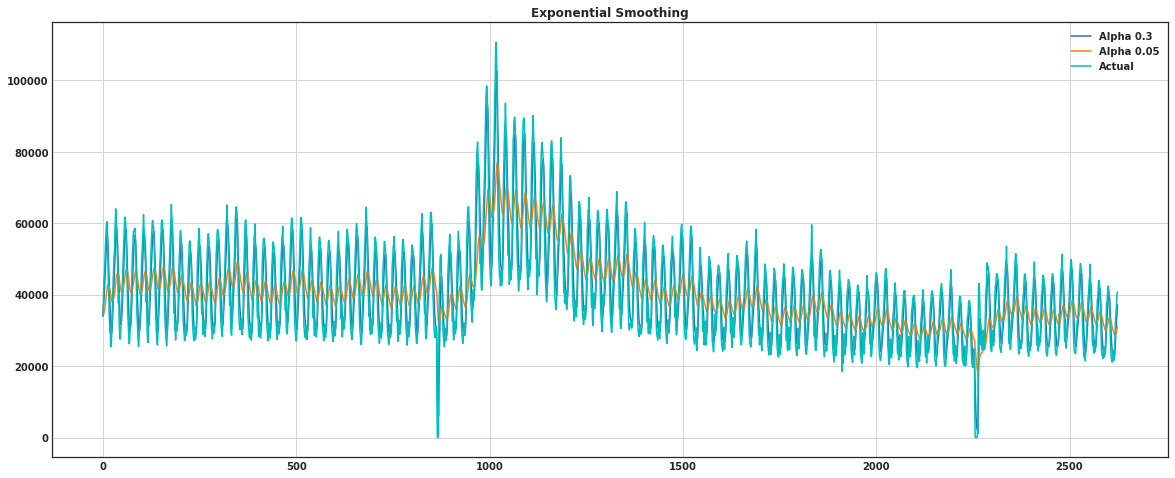

In [10]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Users.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

# Двойное экспоненциальное сглаживание.

In [11]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
#        print('level=',level,' trend=',trend)
        
    return result

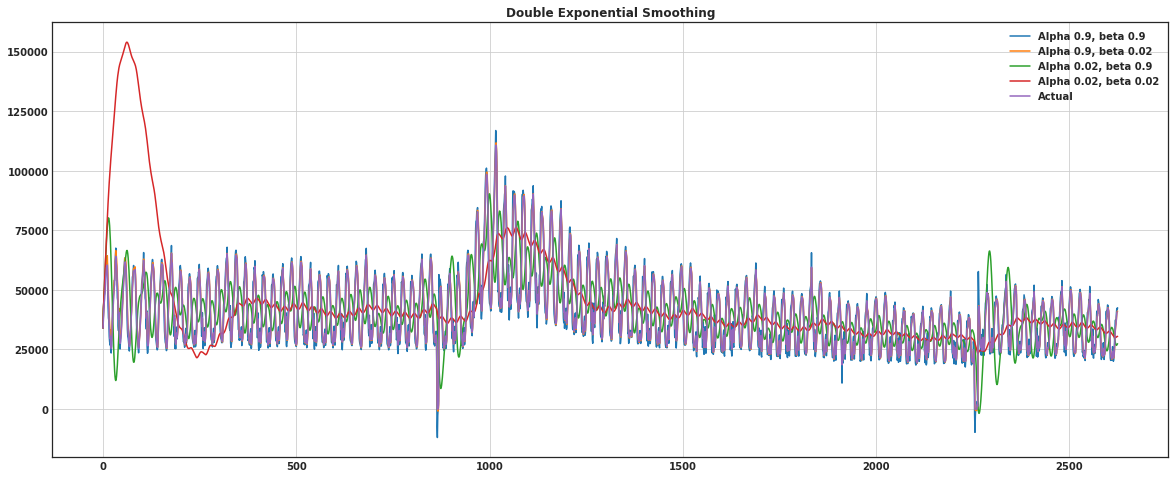

In [12]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

# Тройное экспоненциальное сглаживание (модель Хольта-Винтерса)

In [13]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

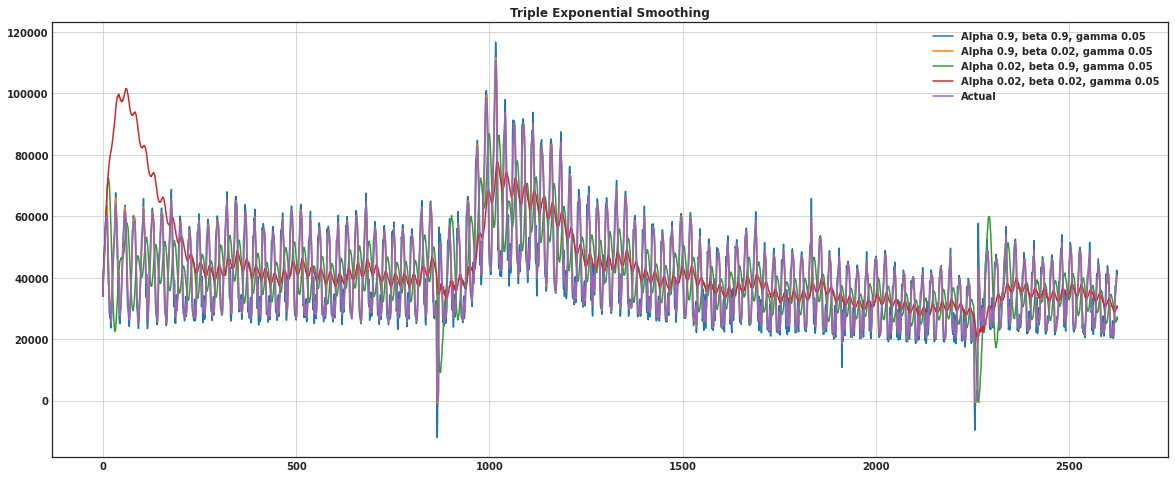

In [14]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
                for gamma in [0.05]:
                    HW = HoltWinters(dataset.Users, 3, alpha, beta, gamma, 1)
                    HW.triple_exponential_smoothing()
                    plt.plot(HW.result, label="Alpha {}, beta {}, gamma {}".format(alpha, beta, gamma))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Triple Exponential Smoothing")
    plt.grid(True)

# Кросс-валидация

### Задание 4. Разбейте временной ряд dataset.Users на части, используя функцию TimeSeriesSplit с количеством фолдов n_splits=3.

In [15]:
from sklearn.model_selection import TimeSeriesSplit

#your code here
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(dataset.Users[:10]):
    print(train_index,test_index)

[0 1 2 3] [4 5]
[0 1 2 3 4 5] [6 7]
[0 1 2 3 4 5 6 7] [8 9]


In [16]:
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [17]:
%%time
data = dataset.Users[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006635880294816432 0.0 0.046569454900318885
Wall time: 20.8 s


In [18]:
data = dataset.Users
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

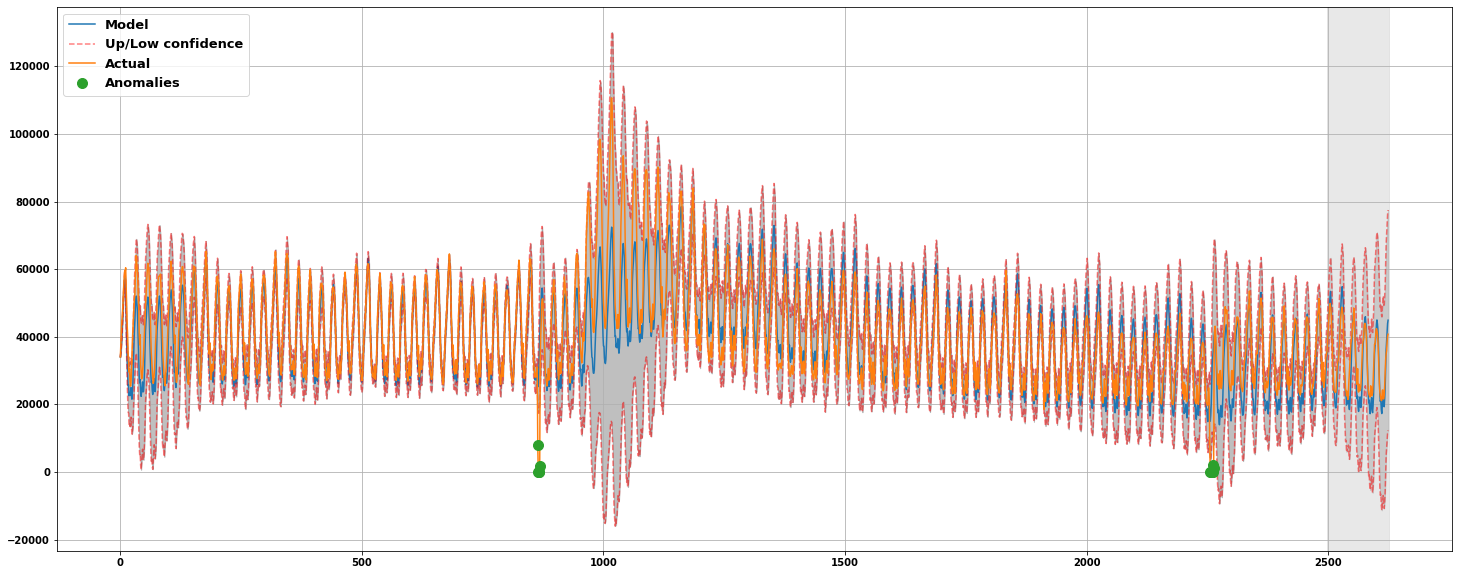

In [19]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

# Машинное обучение. 

## Извлечение признаков

In [20]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [21]:
data.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2017-04-20 00:00:00', '2017-04-20 01:00:00',
               '2017-04-20 02:00:00', '2017-04-20 03:00:00',
               '2017-04-20 04:00:00', '2017-04-20 05:00:00',
               '2017-04-20 06:00:00', '2017-04-20 07:00:00',
               '2017-04-20 08:00:00', '2017-04-20 09:00:00'],
              dtype='datetime64[ns]', name='Time', length=2625, freq=None)

In [22]:
data = pd.DataFrame(dataset)
data.columns = ["y"]

#data.index = data.index.to_datetime()
data["hour"] = data.index.hour

In [23]:
data.head()

,y,hour
Time,,
2017-01-01 00:00:00,34002,0
2017-01-01 01:00:00,37947,1
2017-01-01 02:00:00,41517,2
2017-01-01 03:00:00,44476,3
2017-01-01 04:00:00,46234,4


### Задание 5. Создайте столбец weekday в таблице data, куда запишите день недели, взятый из даты, находящейся в data.index. После этого создайте столбец is_weekend, в который запишите 1, если день недели выходной, и 0 - иначе. 

In [24]:
#your code here
data["weekday"] = 
data["is_weekend"] = 

data.head()

,y,hour,weekday,is_weekend
Time,,,,
2017-01-01 00:00:00,34002,0,6,1
2017-01-01 01:00:00,37947,1,6,1
2017-01-01 02:00:00,41517,2,6,1
2017-01-01 03:00:00,44476,3,6,1
2017-01-01 04:00:00,46234,4,6,1


In [25]:
code_mean(data, 'weekday', "y")

{0: 38730.143229166664,
 1: 38632.828125,
 2: 38128.518229166664,
 3: 39519.035135135135,
 4: 41505.15277777778,
 5: 43717.708333333336,
 6: 43392.14360313316}

Очень хорошими признаками для решения задач, связанных с временными рядами с помощью машинного обучения, являются лаги. Лаг - это ряд, сдвинутый на несколько моментов времени назад.

In [26]:
print(data.y.shift(3))

Time
2017-01-01 00:00:00        NaN
2017-01-01 01:00:00        NaN
2017-01-01 02:00:00        NaN
2017-01-01 03:00:00    34002.0
2017-01-01 04:00:00    37947.0
                        ...   
2017-04-20 05:00:00    25430.0
2017-04-20 06:00:00    29115.0
2017-04-20 07:00:00    33220.0
2017-04-20 08:00:00    34833.0
2017-04-20 09:00:00    35932.0
Name: y, Length: 2625, dtype: float64


### Задание 6. Выведите на экран (с помощью цикла) последние 10 значений первых 10 лагов ряда: сначала 10 значений самого ряда, затем 10 значений ряда, свдинутого на 1, затем 10 значений ряда, сдвинутого на 2 и т.д.

In [27]:
# your code here

Напишем функцию для извлечения всех рассмотренных выше признаков (средние значения, признаки по дате, лаговые признаки).

In [28]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

#    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика

    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))
    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

## Линейная регрессия

In [29]:
dataset.head()

,y,hour,weekday,is_weekend
Time,,,,
2017-01-01 00:00:00,34002,0,6,1
2017-01-01 01:00:00,37947,1,6,1
2017-01-01 02:00:00,41517,2,6,1
2017-01-01 03:00:00,44476,3,6,1
2017-01-01 04:00:00,46234,4,6,1


In [30]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(dataset.y, test_size=0.3, lag_start=1, lag_end=48)
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,is_weekend,weekday_average,hour_average
0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,37652.0,41202.0,48996.0,51527.0,...,52245.0,48842.0,46234.0,44476.0,41517.0,37947.0,34002.0,0,41842.412879,33386.789474
1,31512.0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,37652.0,41202.0,48996.0,...,55245.0,52245.0,48842.0,46234.0,44476.0,41517.0,37947.0,0,42007.075758,34056.272727
2,34801.0,31512.0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,37652.0,41202.0,...,57725.0,55245.0,52245.0,48842.0,46234.0,44476.0,41517.0,0,42007.075758,36313.363636
3,38149.0,34801.0,31512.0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,37652.0,...,59534.0,57725.0,55245.0,52245.0,48842.0,46234.0,44476.0,0,42007.075758,39022.460526
4,41146.0,38149.0,34801.0,31512.0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,...,59285.0,59534.0,57725.0,55245.0,52245.0,48842.0,46234.0,0,42007.075758,44208.467532


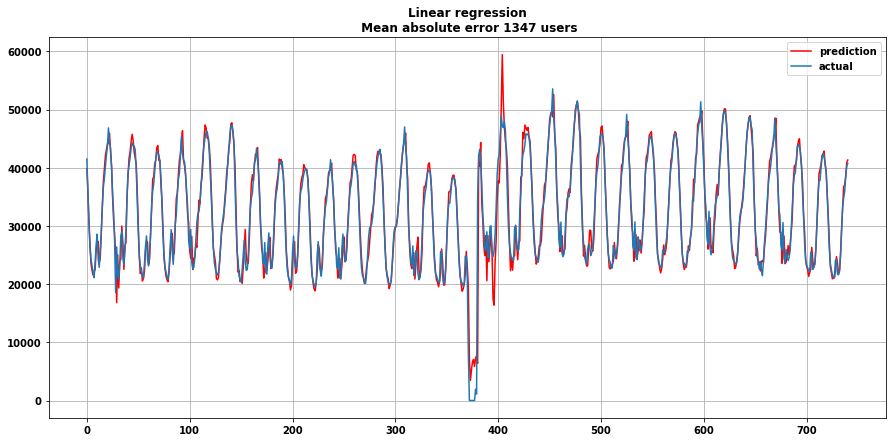

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [32]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [33]:
%%time
X_full, X_, y_full, y_ = prepareData(dataset.y, test_size=0., lag_start=1, lag_end=48)

print(performTimeSeriesCV(X_full, y_full, 5, lr, mean_absolute_error))

Size train set: (2578, 50)
Size of each fold: 515

Splitting the first 2 chunks at 1/2
Size of train + test: (1030, 50)

Splitting the first 3 chunks at 2/3
Size of train + test: (1545, 50)

Splitting the first 4 chunks at 3/4
Size of train + test: (2060, 50)

Splitting the first 5 chunks at 4/5
Size of train + test: (2575, 50)
1607.2991640806063
Wall time: 181 ms


# RandomForest

In [34]:
from sklearn.ensemble import RandomForestRegressor

def RandomForest_forecast(data, lag_start=5, lag_end=20, test_size=0.3, scale=1.96):

    X_train, X_test, y_train, y_test = prepareData(dataset.y, lag_start, lag_end, test_size)

    RF = RandomForestRegressor(n_estimators=100)
    RF.fit(X_train, y_train)
    
    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = RF.predict(X_train)

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = RF.predict(X_test)
    
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(list(y_test), label="y_test")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("RandomForest Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

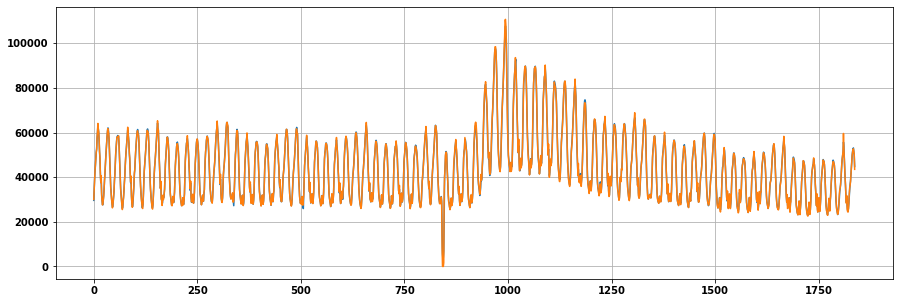

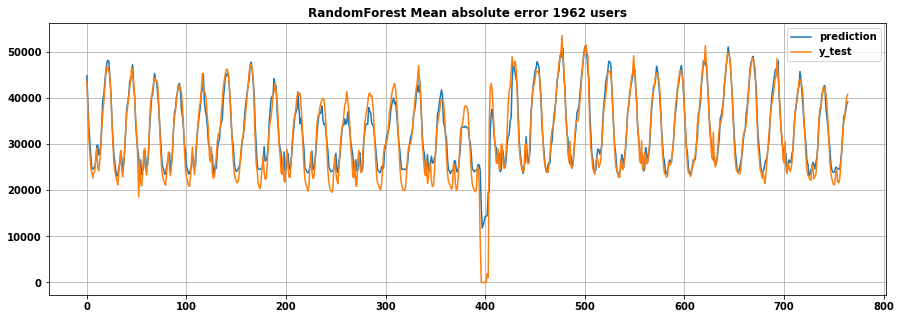

In [35]:
RandomForest_forecast(dataset, test_size=0.3, lag_start=1, lag_end=24)

# Facebook Prophet

In [38]:
from prophet import Prophet

In [39]:
dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])
d = dataset.reset_index()

In [40]:
d.head()

,Time,Users
0,2017-01-01 00:00:00,34002
1,2017-01-01 01:00:00,37947
2,2017-01-01 02:00:00,41517
3,2017-01-01 03:00:00,44476
4,2017-01-01 04:00:00,46234


In [41]:
d.rename(columns = {'Time':'ds', 'Users':'y'}, inplace = True)
print(d.head())

train_dataset = d.iloc[:-800]
test_dataset = d.iloc[-800:]

                   ds      y
0 2017-01-01 00:00:00  34002
1 2017-01-01 01:00:00  37947
2 2017-01-01 02:00:00  41517
3 2017-01-01 03:00:00  44476
4 2017-01-01 04:00:00  46234


In [42]:
train_dataset.head()

,ds,y
0,2017-01-01 00:00:00,34002
1,2017-01-01 01:00:00,37947
2,2017-01-01 02:00:00,41517
3,2017-01-01 03:00:00,44476
4,2017-01-01 04:00:00,46234


In [43]:
m = Prophet() #daily_seasonality, weekly_seasonality
m.fit(train_dataset)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [81]:
future = m.make_future_dataframe(freq='H',periods=300) #freq='H' означает, что измерения проводятся каждый час
future.tail()

,ds
2120,2017-03-30 09:00:00
2121,2017-03-30 10:00:00
2122,2017-03-30 11:00:00
2123,2017-03-30 12:00:00
2124,2017-03-30 13:00:00


In [82]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2120,2017-03-30 09:00:00,45814.362232,29323.644311,60210.890795
2121,2017-03-30 10:00:00,45448.037524,28702.391905,60123.589837
2122,2017-03-30 11:00:00,42832.844031,25701.627844,57693.340470
2123,2017-03-30 12:00:00,38014.331657,20238.377458,52602.417932
2124,2017-03-30 13:00:00,32135.372026,16096.631718,46978.042941


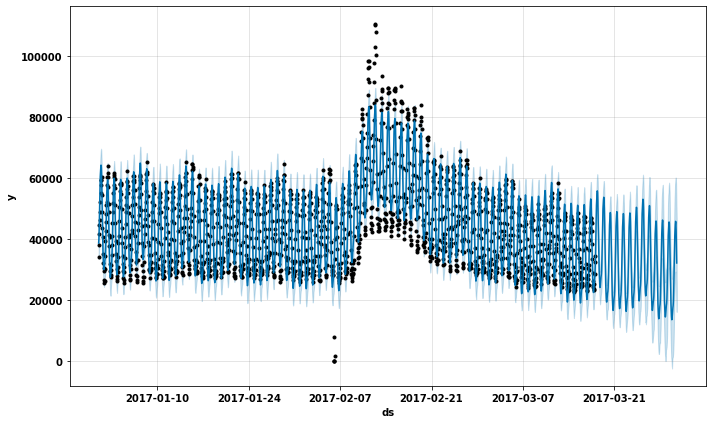

In [83]:
fig1 = m.plot(forecast)

Populating the interactive namespace from numpy and matplotlib


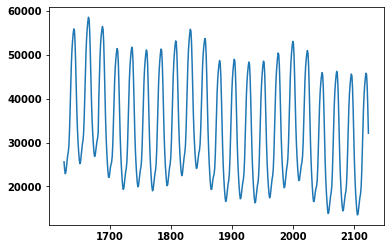

In [84]:
%pylab inline
plot(forecast['yhat'][-500:])

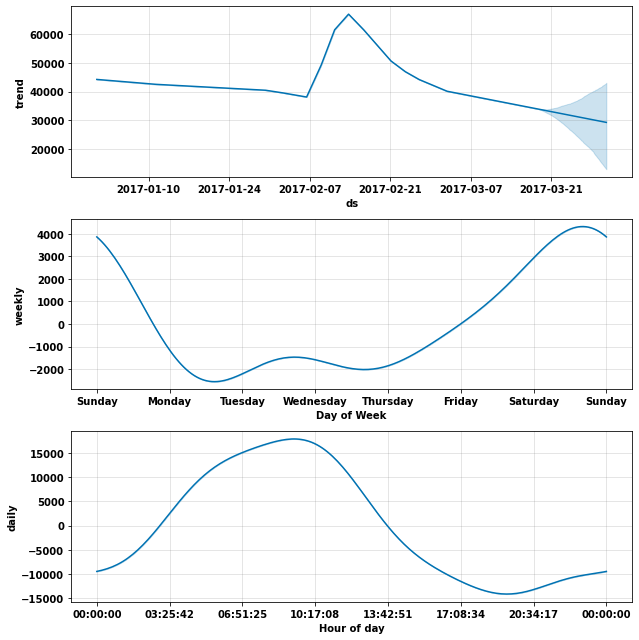

In [85]:
fig2 = m.plot_components(forecast)

In [86]:
metric_df = forecast.set_index('ds')[['yhat']].join(d.set_index('ds').y).reset_index()
metric_df.tail()

,ds,yhat,y
2120,2017-03-30 09:00:00,45814.362232,39192
2121,2017-03-30 10:00:00,45448.037524,41367
2122,2017-03-30 11:00:00,42832.844031,39244
2123,2017-03-30 12:00:00,38014.331657,37515
2124,2017-03-30 13:00:00,32135.372026,34055


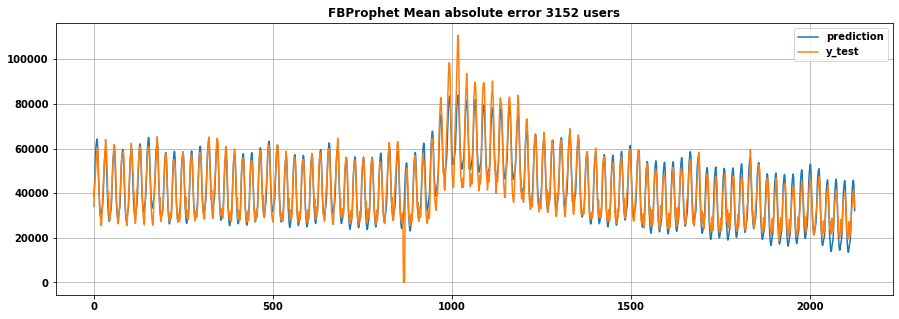

In [87]:
plt.figure(figsize=(15, 5))
plt.plot(metric_df.yhat, label="prediction")
plt.plot(list(metric_df.y), label="y_test")
plt.legend(loc="best")
plt.axis('tight')
plt.title("FBProphet Mean absolute error {} users".format(round(mean_absolute_error(metric_df.yhat, metric_df.y))))
plt.grid(True)
plt.legend()

## Данные по временным рядам 

https://data.world/datasets/time-series

https://archive.ics.uci.edu/ml/datasets.php?format=&task=&att=&area=&numAtt=10to100&numIns=&type=ts&sort=nameUp&view=table

# Задание для самостоятельной работы

Скачайте с одного из предложенных сайтов (или с любого другого) наиболее понравившийся вам датасет и далее работайте с ним.

Разбейте данные на train и test (test - последние 15%-30% данных в зависимости от размера датасета).

1) Постройте адаптивные модели двойного экспоненциального сглаживания и тройного экспоненциального сглаживания. 
Сделайте предсказания и измерьте ошибки mse и mae на train и test.

2*) Исследуйте данные на стационарность. Проверьте наличие сезонных эффектов, зависимостей от предыдущих значений ряда, сбалансируйте дисперсию с помощью преобразования Бокса-Кокса. Приведите ряд к стационарному и примените к полученному стационарному ряду модель ARMA. Подберите параметры p и q для ARMA.

3) Постройте предсказание с помощью модели ARIMA (или SARIMA, если вы подозреваете наличие сезонных эффектов в данных). Измерьте ошибки предсказаний на train и test.

4) Сделайте предсказание с помощью fbprophet и измерьте mse и mae предсказания на train и на test.

5) Поработайте над созданием новых признаков (лаги, аггрегированные признаки и т.д.) и примените для предсказания линейную регрессию и какой-нибудь нелинейный алгоритм.

6) Сравните результаты всех полученных алгоритмов. Какой алгоритм дал наилучшее качество? Какой алгоритм имеет самое маленькое время настройки параметров при хорошем качестве?

7*) Попробуйте скомбинировать наилучшие модели. Улучшилось ли качество предсказания?

Задания 2 и 7 опциональные.